In [38]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

## Minimizing an Arbitrary 1D Function

Suppose we want to find the minimum of the arbitrary function given below:

In [39]:
def arbitrary(x):
    return (x**4 - 15*x**3 + 80*x**2 - 180*x + 144)/10

x = np.linspace(1, 6.75, 200)
fig = px.line(y = arbitrary(x), x = x)


fig.update_layout(font_size = 16)

One way to minimize this mathematical function is to use the `scipy.optimize.minimize` function. It takes a function and a starting guess and tries to find the minimum.

In [40]:
from scipy.optimize import minimize

minimize(arbitrary, x0 = 6)

      fun: -0.6914096788729693
 hess_inv: array([[0.47465475]])
      jac: array([-3.05473804e-06])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([5.3263436])

Our choice of start point can affect the outcome. For example if we start to the left, we get stuck in the local minimum on the left side.

In [41]:
minimize(arbitrary, x0 = 1)

      fun: -0.13827491294422317
 hess_inv: array([[0.74751575]])
      jac: array([-3.7997961e-07])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([2.3927478])

`scipy.optimize.minimize` is great. It may also seem a bit magical. How could you write a function that can find the minimum of any mathematical function? There are a number of ways to do this, which we'll explore in today's lecture, eventually arriving at the important idea of **gradient descent**, which is the principle that `scipy.optimize.minimize` uses.

It turns out that under the hood, the `fit` method for `LinearRegression` models uses gradient descent. Gradient descent is also how much of machine learning works, including even advanced neural network models. 


### The Naive Approach: Guess and Check

Above, we saw that the minimum is somewhere around 5.3ish. Let's see if we can figure out how to find the exact minimum algorithmically from scratch.

One way very slow and terrible way would be manual guess-and-check.

In [42]:
arbitrary(6)

0.0

A somewhat better approach is to use brute force to try out a bunch of x values and return the one that yields the lowest loss.

In [43]:
def simple_minimize(f, xs):
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

In [44]:
simple_minimize(arbitrary, np.linspace(1, 7, 20))

5.421052631578947

This process is essentially the same as before where we made a graphical plot, it's just that we're only looking at 20 selected points.

In [45]:
xs = np.linspace(1, 7, 200)
sparse_xs = np.linspace(1, 7, 5)

ys = arbitrary(xs)
sparse_ys = arbitrary(sparse_xs)

fig = px.line(x = xs, y = arbitrary(xs))
fig.add_scatter(x = sparse_xs, y = arbitrary(sparse_xs), mode = "markers")
fig.update_layout(showlegend= False)
fig.show()

This basic approach suffers from three major flaws:
1. If the minimum is outside our range of guesses, the answer will be completely wrong.
2. Even if our range of guesses is correct, if the guesses are too coarse, our answer will be inaccurate.
3. It is absurdly computationally inefficient, considering potentially vast numbers of guesses that are useless.

### Better Approach: Gradient Descent

Instead of choosing all of our guesses ahead of time, we can instead start from a single guess and try to iteratively improve on our choice. 

They key insight is this: If the derivative of the function is negative, that means the function is decreasing, so we should go to the right (i.e. pick a bigger x). If the derivative of the function is positive, that means the function is increasing, so we should go to the left (i.e. pick a smaller x).

Thus, the derivative tells us which way to go.

In [46]:
import plotly.graph_objects as go

def derivative_arbitrary(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10


fig = go.Figure()
roots = np.array([2.3927, 3.5309, 5.3263])

fig.add_trace(go.Scatter(x = xs, y = arbitrary(xs), 
                         mode = "lines", name = "f"))
fig.add_trace(go.Scatter(x = xs, y = derivative_arbitrary(xs), 
                         mode = "lines", name = "df", line = {"dash": "dash"}))
fig.add_trace(go.Scatter(x = np.array(roots), y = 0*roots, 
                         mode = "markers", name = "df = zero", marker_size = 12))
fig.update_layout(font_size = 20, yaxis_range=[-1, 3])
fig.show()

In [47]:
import matplotlib.pyplot as plt

def plot_arbitrary():
    x = np.linspace(1, 7, 100)
    plt.plot(x, arbitrary(x))
    axes = plt.gca()
    axes.set_ylim([-1, 3])
    
def plot_x_on_f(f, x):
    y = f(x)    
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([x], [y], **default_args)
    
def plot_x_on_f_empty(f, x):
    y = f(x)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c = 'none', edgecolor=sns.xkcd_rgb['green'])
    plt.scatter([x], [y], **default_args)    
    
def plot_tangent_on_f(f, x, eps=1e-6):
    slope = ((f(x + eps) - f(x - eps))
             / (2 * eps))
    xs = np.arange(x - 1, x + 1, 0.05)
    ys = f(x) + slope * (xs - x)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')    

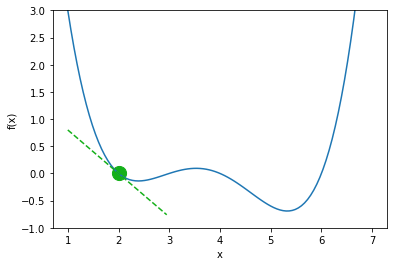

In [48]:
plot_arbitrary()
plot_x_on_f(arbitrary, 2)
plot_tangent_on_f(arbitrary, 2)
plt.xlabel('x')
plt.ylabel('f(x)');

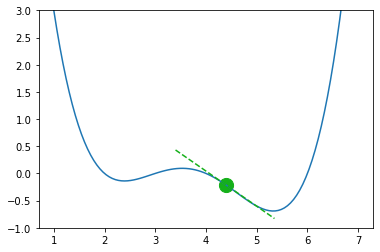

In [49]:
plot_arbitrary()
plot_x_on_f(arbitrary, 4.4)
plot_tangent_on_f(arbitrary, 4.4)

## Manually Descending the Gradient

Armed with this knowledge, let's try to see if we can use the derivative to optimize the function.

In [50]:
guess = 4
print(f"x: {guess}, f(x): {arbitrary(guess)}, derivative f'(x): {derivative_arbitrary(guess)}")

x: 4, f(x): 0.0, derivative f'(x): -0.4


In [51]:
guess = 4 + 0.4
print(f"x: {guess}, f(x): {arbitrary(guess)}, derivative f'(x): {derivative_arbitrary(guess)}")

x: 4.4, f(x): -0.21504000000003315, derivative f'(x): -0.6464000000000055


In [52]:
def plot_one_step(x):
    new_x = x - derivative_arbitrary(x)
    plot_arbitrary()
    plot_x_on_f(arbitrary, new_x)
    plot_x_on_f_empty(arbitrary, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.4


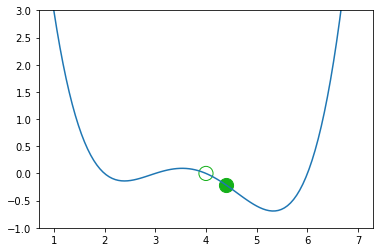

In [53]:
plot_one_step(4)

old x: 4.4
new x: 5.0464000000000055


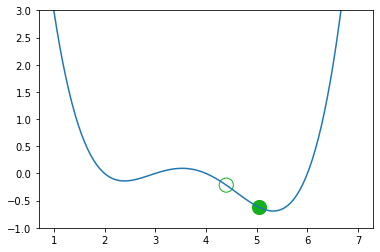

In [54]:
plot_one_step(4.4)

old x: 5.0464
new x: 5.49673060106241


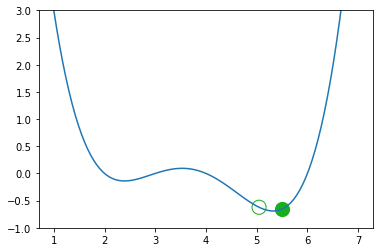

In [55]:
plot_one_step(5.0464)

old x: 5.4967
new x: 5.080917145374805


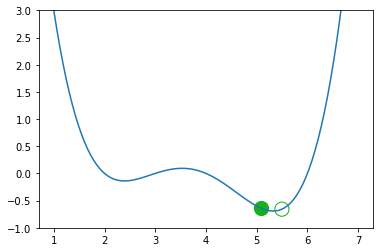

In [56]:
plot_one_step(5.4967)

old x: 5.080917145374805
new x: 5.489966698640582


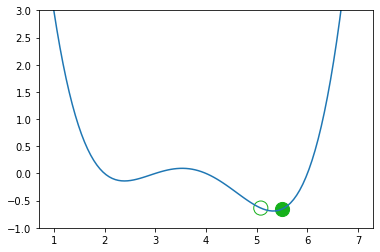

In [57]:
plot_one_step(5.080917145374805)

old x: 5.489966698640582
new x: 5.092848945470474


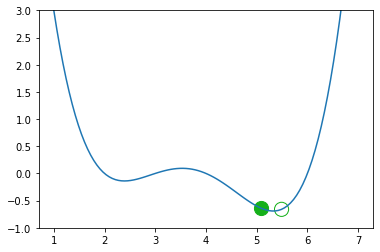

In [58]:
plot_one_step(5.489966698640582)

In [59]:
def plot_one_step_better(x):
    new_x = x - 0.3 * derivative_arbitrary(x)
    plot_arbitrary()
    plot_x_on_f(arbitrary, new_x)
    plot_x_on_f_empty(arbitrary, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.12


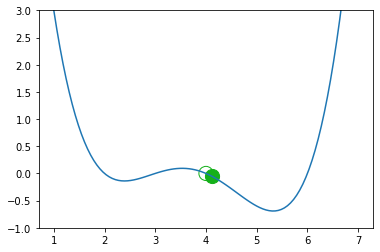

In [60]:
plot_one_step_better(4)

old x: 4.12
new x: 4.267296639999997


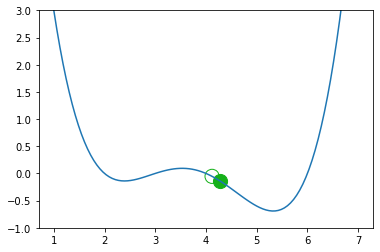

In [61]:
plot_one_step_better(4.12)

old x: 5.17180969114245
new x: 5.256374838146257


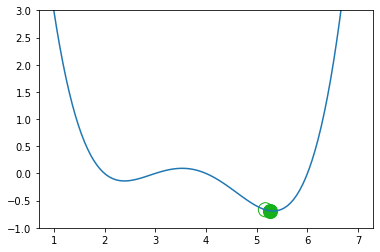

In [62]:
plot_one_step_better(5.17180969114245)

old x: 5.323
new x: 5.325108157959999


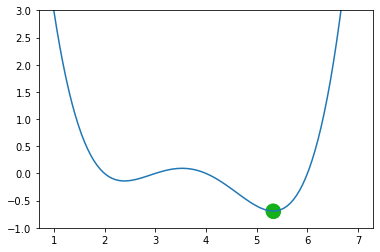

In [63]:
plot_one_step_better(5.323)

## Gradient Descent as an Algorithmic Procedure in Code

Written as a recurrence relation, the process we've described above is:

$$
x^{(t+1)} = x^{(t)} -  0.3 \frac{d}{dx} f(x)
$$

This algorithm is also known as "gradient descent". 

Given a current $x$, gradient descent creates its next guess for $x$ based on the sign and magnitude of the derivative.

Our choice of 0.3 above was totally arbitrary. Naturally, we can generalize by replacing it with a parameter, typically represented by $\alpha$, and often called the "learning rate".

$$
x^{(t+1)} = x^{(t)} -  \alpha \frac{d}{dx} f(x)
$$

We can also write up this procedure in code as given below:

In [64]:
def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

In [65]:
trajectory = gradient_descent(derivative_arbitrary, 4, 0.3, 20)
trajectory

array([4.        , 4.12      , 4.26729664, 4.44272584, 4.64092624,
       4.8461837 , 5.03211854, 5.17201478, 5.25648449, 5.29791149,
       5.31542718, 5.3222606 , 5.32483298, 5.32578765, 5.32614004,
       5.32626985, 5.32631764, 5.32633523, 5.3263417 , 5.32634408])

In [66]:
trajectory = gradient_descent(derivative_arbitrary, 4, 1, 20)
trajectory

array([4.        , 4.4       , 5.0464    , 5.4967306 , 5.08086249,
       5.48998039, 5.09282487, 5.48675539, 5.09847285, 5.48507269,
       5.10140255, 5.48415922, 5.10298805, 5.48365325, 5.10386474,
       5.48336998, 5.1043551 , 5.48321045, 5.10463112, 5.48312031])

Below, we see a visualization of the trajectory taken by this algorithm.

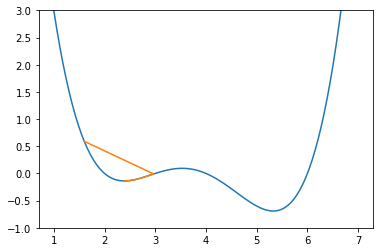

In [67]:
trajectory = gradient_descent(derivative_arbitrary, 1.6, 0.6, 20)
plot_arbitrary()
plt.plot(trajectory, arbitrary(trajectory));

Above, we've simply run our algorithm a fixed number of times. More sophisticated implementations will stop based on a variety of different stopping criteria, e.g. error getting too small, error getting too large, etc. We will not discuss these in our course.

In the next part, we'll return to the world of real data and see how this procedure might be useful for optimizing models.

## Linear Regression With No Offset

Let's consider a case where we have a linear model with no offset. 

$$\hat{y} = \theta_1 x$$

We want to find the parameter $\theta_1$ such that the L2 loss is minimized. In sklearn, this is easy. To avoid fitting an intercept, we set `fit_intercept` to false.

In [68]:
df = sns.load_dataset("tips")
df.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In [69]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept = False)
model.fit(df[["total_bill"]], df["tip"])
model.coef_

array([0.1437319])

The optimal tip percentage is 14.37%.

#### Creating an Explicit MSE Function

To employ gradient descent and do this ourselves, we need to define a function upon which we can use gradient descent.

Suppose we select the L2 loss as our loss function. In this case, our goal will be to minimize the mean squared error. 

Let's start by writing a function that computes the MSE for a given choice of $\theta_1$ on our dataset.

In [70]:
def mse_loss(theta1, x, y_obs):
    y_hat = theta1 * x
    return np.mean((y_hat - y_obs) ** 2)    

In [72]:
x = df["total_bill"]
y_obs = df["tip"]
mse_loss(0.147, x, y_obs)

1.1831403511422134

Since `x` and `y_obs` are fixed, the only variable is `theta1`. 

For clarity, let's define a python function that returns the MSE as a function of a single argument `theta1`.

In [73]:
def mse_single_arg(theta1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta1 * x
    return np.mean((y_hat - y_obs) ** 2) 

In [74]:
mse_single_arg(0.1437)

1.1781165940051928

#### Brute Forcing our Explicit MSE Function

Thus we can plot the MSE as a function of `theta1`. It turns out to look pretty smooth, and quite similar to a parabola.

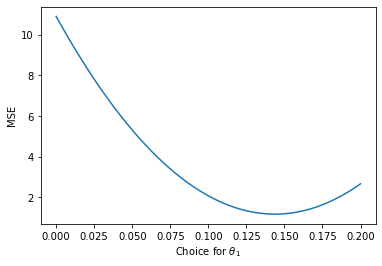

In [75]:
theta1s = np.linspace(0, 0.2, 200)
x = df["total_bill"]
y_obs = df["tip"]

MSEs = [mse_single_arg(theta1) for theta1 in theta1s]

plt.plot(theta1s, MSEs)
plt.xlabel(r"Choice for $\theta_1$")
plt.ylabel(r"MSE");

The minimum appears to be around $\theta_1 = 0.14$.

Recall our simple_minimize function from earlier, redefined below for your convenience.

In [76]:
def simple_minimize(f, xs):
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

In [77]:
simple_minimize(mse_single_arg, np.linspace(0, 0.2, 21))

0.14

As before, what we're doing is computing all the starred values below and then returning the $\theta_1$ that goes with the minimum value.

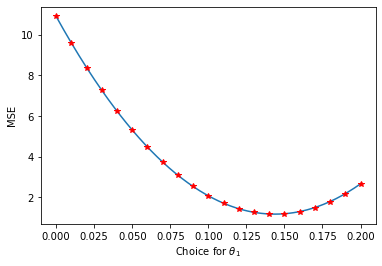

In [78]:
theta1s = np.linspace(0, 0.2, 200)
sparse_theta1s = np.linspace(0, 0.2, 21)

loss = [mse_single_arg(theta1) for theta1 in theta1s]
sparse_loss = [mse_single_arg(theta1) for theta1 in sparse_theta1s]

plt.plot(theta1s, loss)
plt.plot(sparse_theta1s, sparse_loss, 'r*')
plt.xlabel(r"Choice for $\theta_1$")
plt.ylabel(r"MSE");

#### Using Scipy.Optimize.minimize

In [79]:
import scipy.optimize
from scipy.optimize import minimize
minimize(mse_single_arg, x0 = 0)

      fun: 1.1781161154513213
 hess_inv: array([[1]])
      jac: array([4.24683094e-06])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([0.14373189])

#### Using Our Gradient Descent Function

Another approach is to use our 1D gradient descent algorithm from earlier. This is the exact same function as earlier, but copy and pasted to remind you what it looks like.

In [80]:
def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

To use this function, we need to compute the derivative of the MSE. The MSE is repeated below for convenience.

In [81]:
def mse_single_arg(theta1):
    """Returns the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta1 * x
    return np.mean((y_hat - y_obs) ** 2) 

So the derivative is therefore:

In [82]:
def mse_loss_derivative_single_arg(theta_1):
    """Returns the derivative of the MSE on our data for the given theta1"""
    x = df["total_bill"]
    y_obs = df["tip"]
    y_hat = theta_1 * x
    
    return np.mean(2 * (y_hat - y_obs) * x)

In [83]:
gradient_descent(mse_loss_derivative_single_arg, 0.05, 0.0001, 100)

array([0.05      , 0.05881852, 0.06680736, 0.0740446 , 0.08060095,
       0.08654045, 0.09192116, 0.09679563, 0.10121151, 0.10521192,
       0.10883597, 0.11211906, 0.11509327, 0.11778766, 0.12022855,
       0.1224398 , 0.12444301, 0.12625776, 0.12790176, 0.1293911 ,
       0.13074031, 0.13196259, 0.13306988, 0.13407298, 0.13498172,
       0.13580495, 0.13655074, 0.13722636, 0.13783841, 0.13839289,
       0.13889519, 0.13935024, 0.13976248, 0.14013593, 0.14047425,
       0.14078073, 0.14105839, 0.14130992, 0.14153778, 0.14174421,
       0.14193122, 0.14210063, 0.1422541 , 0.14239314, 0.14251909,
       0.14263319, 0.14273656, 0.1428302 , 0.14291504, 0.14299189,
       0.14306151, 0.14312458, 0.14318172, 0.14323348, 0.14328037,
       0.14332285, 0.14336134, 0.1433962 , 0.14342778, 0.14345639,
       0.14348231, 0.1435058 , 0.14352707, 0.14354634, 0.1435638 ,
       0.14357961, 0.14359394, 0.14360692, 0.14361868, 0.14362933,
       0.14363898, 0.14364772, 0.14365564, 0.14366281, 0.14366

In the context of minimizing loss, we can write out the gradient descent rule for generating the next $\theta_1$ as:

$$
\theta_1^{(t+1)} = \theta_1^{(t)} - \alpha \frac{\partial}{\partial \theta_1} L(\theta^{(t)}, \Bbb{X}, \vec{\hat{y}})
$$

Here $L$ is our chosen loss function, $\Bbb{X}$ are the features of our input, and $\vec{\hat{y}}$ are our observations. During the gradient descent algorithm, we treat $\Bbb{X}$ and $\vec{\hat{y}}$ as constants.

## Multi Dimensional Models

Now suppose we improve our model so that we want to predict the tip from the total_bill plus a constant offset, in other words:

$$\textrm{tip} = \theta_0 + \theta_1 \textrm{bill}$$

We know how to do this in sklearn:

In [84]:
model = LinearRegression(fit_intercept = True)
X = df[["total_bill"]]
y = df["tip"]
model.fit(X, y)

LinearRegression()

In [85]:
model.coef_

array([0.10502452])

In [86]:
model.intercept_

0.9202696135546731

### With sklearn (explicit bias column)

To make our lives easier, let's reframe the problem slightly:

In [87]:
tips_with_bias = df.copy()
tips_with_bias["bias"] = 1
X = tips_with_bias[["bias", "total_bill"]]
X.head(5)

bias  total_bill
0     1       16.99
1     1       10.34
2     1       21.01
3     1       23.68
4     1       24.59

In [88]:
model = LinearRegression(fit_intercept = False)
X = tips_with_bias[["bias", "total_bill"]]
y = df["tip"]
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [89]:
model.coef_

array([0.92026961, 0.10502452])

#### Defining a 2D MSE Function

Now, we can give our predictions as $$\hat{y} = \theta_0 + \theta_1 \times bill$$

For example, the predictions below correspond to assuming every table leaves a tip of \$1.50 plus 5% of their total bill.

In [90]:
X @ np.array([1.5, 0.05]) 

0      2.3495
1      2.0170
2      2.5505
3      2.6840
4      2.7295
        ...  
239    2.9515
240    2.8590
241    2.6335
242    2.3910
243    2.4390
Length: 244, dtype: float64

Throughout this problem, we'll assume we want to minimize the mean squared error of our predictions, i.e.

In [91]:
def mse_loss(theta, X, y_obs):
    y_hat = X @ theta
    return np.mean((y_hat - y_obs) ** 2)    

For example, the loss assuming the model described above is:

In [92]:
mse_loss(np.array([1.5, 0.05]), X, y_obs)

1.534052175204919

Using this function, we can create a 3D plot. This uses lots of syntax you've never seen.

In [93]:
import plotly.graph_objects as go

uvalues = np.linspace(0, 2, 10)
vvalues = np.linspace(0, 0.2, 10)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))

def mse_loss_single_arg(theta):
    return mse_loss(theta, X, y_obs)

MSE = np.array([mse_loss_single_arg(t) for t in thetas.T])

loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

ind = np.argmin(MSE)
optimal_point = go.Scatter3d(name = "Optimal Point",
    x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
    z = [MSE[ind]],
    marker=dict(size=10, color="red"))

fig = go.Figure(data=[loss_surface, optimal_point])
fig.update_layout(scene = dict(
    xaxis_title = "theta0",
    yaxis_title = "theta1",
    zaxis_title = "MSE"))
fig.show()

## Optimizing the 2D Model With Our Own Gradient Descent

Below is the function we just derived, but in code.

In [94]:
def mse_gradient(theta, X, y_obs):
    """Returns the gradient of the MSE on our data for the given theta"""    
    x0 = X.iloc[:, 0]
    x1 = X.iloc[:, 1]
    dth0 = np.mean(-2 * (y_obs - theta[0]*x0 - theta[1]*x1) * x0)
    dth1 = np.mean(-2 * (y_obs - theta[0]*x0 - theta[1]*x1) * x1)
    return np.array([dth0, dth1])

In [95]:
X = tips_with_bias[["bias", "total_bill"]]
y_obs = tips_with_bias["tip"]
mse_gradient(np.array([0, 0]), X, y_obs)

array([  -5.99655738, -135.22631803])

In [96]:
def mse_gradient_single_arg(theta):
    """Returns the gradient of the MSE on our data for the given theta"""
    X = tips_with_bias[["bias", "total_bill"]]
    y_obs = tips_with_bias["tip"]
    return mse_gradient(theta, X, y_obs)

In [97]:
mse_gradient_single_arg(np.array([0, 0]))

array([  -5.99655738, -135.22631803])

In [98]:
guesses = gradient_descent(mse_gradient_single_arg, np.array([0, 0]), 0.001, 10000)

In [99]:
pd.DataFrame(guesses).tail(10)

0         1
9990  0.888098  0.106378
9991  0.888108  0.106378
9992  0.888119  0.106377
9993  0.888130  0.106377
9994  0.888141  0.106376
9995  0.888151  0.106376
9996  0.888162  0.106375
9997  0.888173  0.106375
9998  0.888184  0.106375
9999  0.888194  0.106374

If you play around with the code above, you'll see that it's pretty finicky about the start point and learning rate. 

## Extra

For reference, the general matrix form of the gradient is given below. We have not discussed how to derive this in class.

In [100]:
def mse_gradient(theta, X, y_obs):
    """Returns the gradient of the MSE on our data for the given theta"""
    n = len(X)
    return -2 / n * (X.T @ y_obs - X.T @ X @ theta)